In [1]:
import numpy as np
from scipy.stats import chi2_contingency, chi2, chisquare
from pyprojroot import here
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Chi-squared testing

This notebook demonstrates the following variations of the Chi-squared test:
1. Chi-squared test of independence
    - Whether two categorical variables are independent
2. Chi-squared goodness-of-fit test
    - Whether the distribution of a single categorical variable matches an expected distribution
3. Chi-squared test of Homogeneity
    - Whether two or more independent groups share the same distribution of a categorical variable


## Introduction

This section provides a general introduction to Chi-squared testing. For any specifics of the Chi-squared variants, see individual sections:
- [**Test of Independence**](#Test-of-Independence)
- [**Goodness-of-fit Test**](#Goodness-of-fit-Test)
- [**Test of Homogeniety**](#Test-of-Homogeneity)

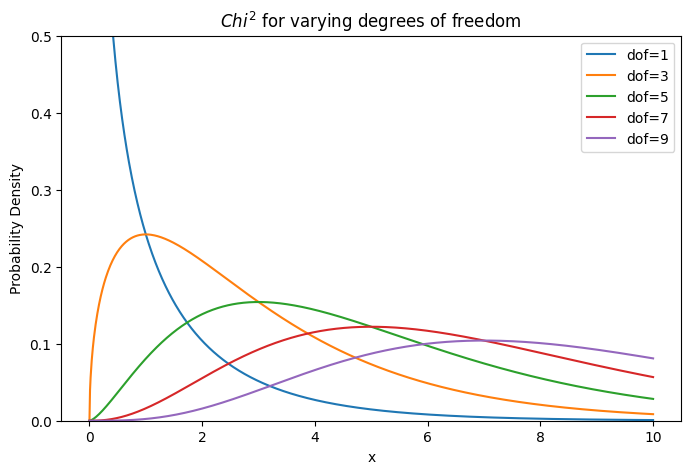

In [2]:
x = np.linspace(0, 10, 1000)

plt.figure(figsize=(8, 5))
plt.ylim(0, 0.5)

for dof in (1, 3, 5, 7, 9):
    plt.plot(x, chi2.pdf(x, dof), label=f"{dof=}")

plt.title('$Chi^2$ for varying degrees of freedom')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()

## Requirements

This notebook uses the `Heart Failure Prediction Dataset` which can be found [here](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) (08/06/2025). The dataset should be downloaded and placed into the `data` directory at the project root.

In [3]:
df_original = pd.read_csv(here("data/heart.csv"))
df_original.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Test of Independence

For this example, we will test if the *biological sex (M/F)* of an individual affects heart disease. We can formulate the above as such:

**Hypotheses**

$ Let\ X\ = biological\ sex,\ Y = heart\ failure $ 
- $ H_0: P(Y | X) = P(Y) $ (Y is independent of X)
- $ H_a: P(Y | X) \neq P(Y)$ (Y depends on X)

We shall use an alpha value of 0.05 to determine significance.

$$ alpha = 0.05 $$

To ease demonstration let's filter the original data for only the columns needed for this example.

In [4]:
df_independence = df_original[["Sex", "HeartDisease"]]
df_independence.head()

,Sex,HeartDisease
0,M,0
1,F,1
2,M,0
3,F,1
4,M,0


The chi-squared test requires a contingency table. This can easily be done using `pandas'` `crosstab()` function.

In [5]:
contingency = pd.crosstab(df_independence["Sex"], df_independence["HeartDisease"])
contingency

HeartDisease,0,1
Sex,,
F,143,50
M,267,458


Perform the test using `scipy's` `chi2_contingency` function.

In [6]:
chi2_stat, p_chi, df, expected = chi2_contingency(contingency)

print(f"chi2 statistic: {chi2_stat:.4f}")
print(f"p-value: {p_chi:.4f}")

chi2 statistic: 84.1451
p-value: 0.0000


Observations:
- A Chi-squared test statistic of 84.15 indicates that the observed differences between heart failure rates in males and females are large relative to what would be expected if the two variables were independent. This suggests a potential association between biological sex and heart failure outcome.
- A p-value < 0.001 is much smaller than our alpha of 0.05

In conclusion, based off of the above results, we reject the null hypothesis of independence and conclude that there is strong statistical evidence of an association between biological sex and heart failure.

We can plot our statistic visually against the chi-squared distribution.

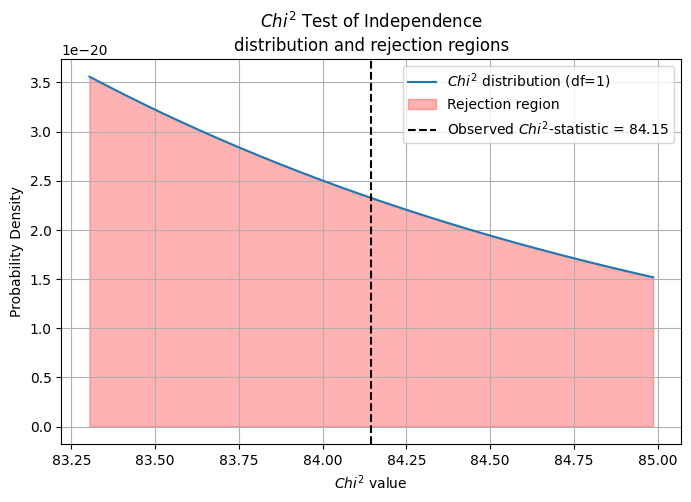

In [7]:
# Parameters
alpha = 0.05

# Define x range ±1% around statistic
# chi2 distribution is non-negative
x_min = max(0, chi2_stat * 0.99)
x_max = chi2_stat * 1.01
x = np.linspace(x_min, x_max, 500)
y = chi2.pdf(x, df)

plt.figure(figsize=(8, 5))
plt.plot(x, y, label=f'$Chi^2$ distribution (df={df:.0f})')

# shade rejection region
plt.fill_between(x, 0, y, color='red', alpha=0.3, label='Rejection region')

# mark statistic
plt.axvline(chi2_stat, color='black', linestyle='--', label=f'Observed $Chi^2$-statistic = {chi2_stat:.2f}')

plt.title('$Chi^2$ Test of Independence\ndistribution and rejection regions')
plt.xlabel('$Chi^2$ value')
plt.ylabel('Probability Density')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

We can examine what a contingency table *would* look like if there was *no* observed association between biological sex and heart failure. 

In [8]:
expected_contingency = pd.DataFrame(expected, index=contingency.index, columns=contingency.columns)
expected_contingency

HeartDisease,0,1
Sex,,
F,86.198257,106.801743
M,323.801743,401.198257


From this, let's calculate the standardised residuals (by expected) to see where the largest deviations occur.

In [9]:
residuals = (contingency - expected_contingency) / expected_contingency.pow(0.5) 
residuals

HeartDisease,0,1
Sex,,
F,6.118042,-5.496326
M,-3.156618,2.835843


<Axes: xlabel='HeartDisease', ylabel='Sex'>

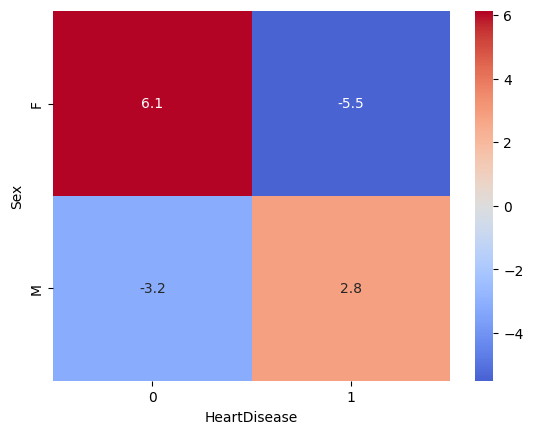

In [10]:
sns.heatmap(residuals, annot=True, cmap="coolwarm", center=0)

Standardised residuals observations:
- Females: Far more without heart disease (+6.1) than expected, and far less with heart disease than expected (-5.5), assuming independence
- Males: Fewer men without heart disease than expected (-3.2), and more men with heart disease than expected (2.8), again, assuming independence

It is important to note the contrasting pattern across the diagonals of the residuals matrix:
- The top-left -> bottom-right diagonal (females without heart disease and males with heart disease) shows more occurrences than expected under the assumption of independence.
- The bottom-left -> top-right diagonal (females with heart disease and males without heart disease) shows fewer occurrences than expected.

This diagonal pattern supports the conclusion that males are more likely to have heart disease than females in this dataset, indicating a significant association between biological sex and heart disease occurrence in this data.

## Goodness-of-fit Test

For this example, we will examine if the dataset is balanced in terms of *biological sex (M/F)*. This can be formulated as such:

**Hypotheses**
- $ H_0: $ The observed frequencies of biological sex **follow a uniform distribution**, that is there is an equal split of males (M) and females (F)
- $ H_a: $ The observed frequencies of biological sex **do not follow a uniform distribution**, the proportions of males and female are not equal.

Again, we shall use an alpha value of 0.05 to determine significance.

$$ alpha = 0.05 $$

Again, let's let's filter the original data for only the columns needed for this example.

In [11]:
df_fit = df_original[["Sex"]]
df_fit.head()

,Sex
0,M
1,F
2,M
3,F
4,M


Let's first examine the proportion of males (M) to females (F) via a pie chart.

<Axes: ylabel='count'>

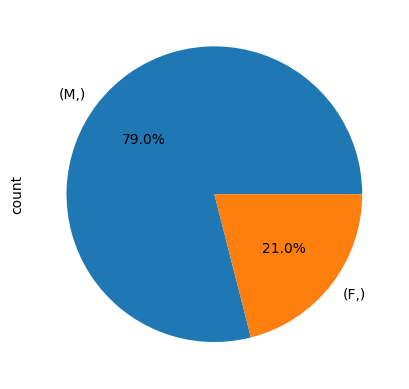

In [12]:
df_fit.value_counts().plot(kind="pie", autopct='%1.1f%%')

Although the imbalance between males and females is visually clear (79% males vs. 21% females), performing a chi-squared goodness-of-fit test formally confirms this.

In [13]:
observed = df_fit.value_counts().to_numpy()
expected_dist = np.array([0.5, 0.5])
expected = expected_dist * observed.sum()

chi2_stat, p_chi = chisquare(f_obs=observed, f_exp=expected)

print(f"chi2 statistic: {chi2_stat:.4f}")
print(f"p-value: {p_chi:.4f}")

chi2 statistic: 308.3050
p-value: 0.0000


Observations:
- A Chi-squared test statistic of 308.3050 indicates a large difference between the observed and expected frequencies of biological sex in the dataset, assuming equal proportions.
- A p-value < 0.001 is much smaller than our alpha of 0.05

In conclusion, based off of the above results, we reject the null hypothesis and conclude that the distribution of biological sex within the dataset **does not** follow a uniform distribution.

### Further Intuition

To satisfy my curitosity, let's now plot the $Chi^2$ statistic and p-value as the ratio of males / females approaches 1, i.e. as the data approaches a uniform distribution.

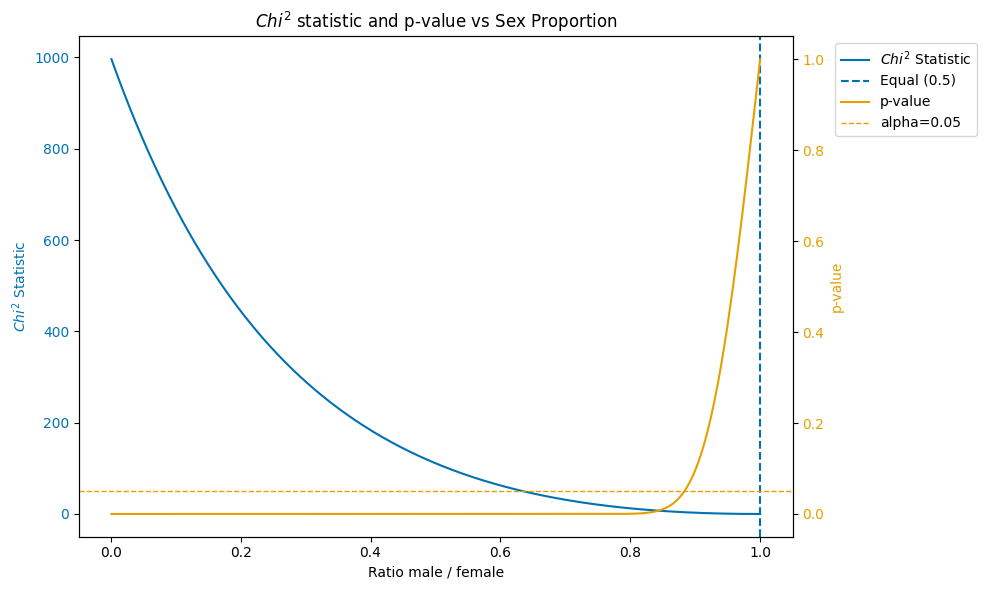

In [14]:
n = 1000

proportions = list(range(1, n))
proportions = proportions[:int(n / 2)]

chi_values = []
p_values = []
ratio_mf = []

expected = [0.5 * n, 0.5 * n]
for n_males in proportions:
    n_females = n - n_males
    observed = [n_males, n_females]
    ratio_mf.append(n_males / n_females)

    stat, p = chisquare(f_obs=observed, f_exp=expected)

    chi_values.append(stat)
    p_values.append(p)

# plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

chi_colour = "#0072B2"
p_colour = "#E69F00"

# chi statistic
ax1.plot(ratio_mf, chi_values, color=chi_colour, label='$Chi^2$ Statistic')
ax1.set_xlabel('Ratio male / female')
ax1.set_ylabel('$Chi^2$ Statistic', color=chi_colour)
ax1.tick_params(axis='y', labelcolor=chi_colour)

# p-values
ax2 = ax1.twinx()
ax2.plot(ratio_mf, p_values, color=p_colour, label='p-value')
ax2.set_ylabel('p-value', color=p_colour)
ax2.tick_params(axis='y', labelcolor=p_colour)

# reference lines
ax2.axhline(0.05, color=p_colour, linestyle='--', linewidth=1, label='alpha=0.05')
ax1.axvline(1, color=chi_colour, linestyle='--', label='Equal (0.5)')

# combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, bbox_to_anchor=(1.05, 1))

plt.title('$Chi^2$ statistic and p-value vs Sex Proportion')
# plt.grid(True)
plt.tight_layout()
plt.show()


As expected, we observe that as the observed distribution approaches the expected uniform distribution:
- The chi-squared statistic approaches 0
- The p-value approaches 1

## Test of Homogeneity

For this example, we will test if males and females with heart disease experiance different types of chest pain at similar rates. This can be formulated a such:

**Hypotheses**
- $ H_0: $ The distribution of chest pain types is the same for males and females with heart disease.
- $ H_a: $ The distribution of chest pain types is different for males and females with heart disease.

Again, we shall use an alpha value of 0.05 to determine significance.

$$ alpha = 0.05 $$

Again, let's let's filter the original data for only the columns needed for this example.

In [15]:
df_homogeneity = df_original[["Sex", "ChestPainType", "HeartDisease"]]
df_homogeneity.head()

,Sex,ChestPainType,HeartDisease
0,M,ATA,0
1,F,NAP,1
2,M,ATA,0
3,F,ASY,1
4,M,NAP,0


Much like we did with the previous example, let's first plot the distributions of `ChestPainType` for heart disease patients.

In [16]:
# filter for only heart disease
df_homogeneity = df_homogeneity[df_homogeneity["HeartDisease"] == 1]

# count the heart pain types amongst the groups
counts = df_homogeneity.groupby(["Sex"]).value_counts().to_frame()
counts = counts.reset_index()

# normalise by sum of sex
sex_totals = counts.groupby("Sex")["count"].transform("sum")
counts["Proportion"] = counts["count"] / sex_totals

Text(0.5, 1.0, 'Chest Pain Type Distribution by Sex in Heart Disease Patients')

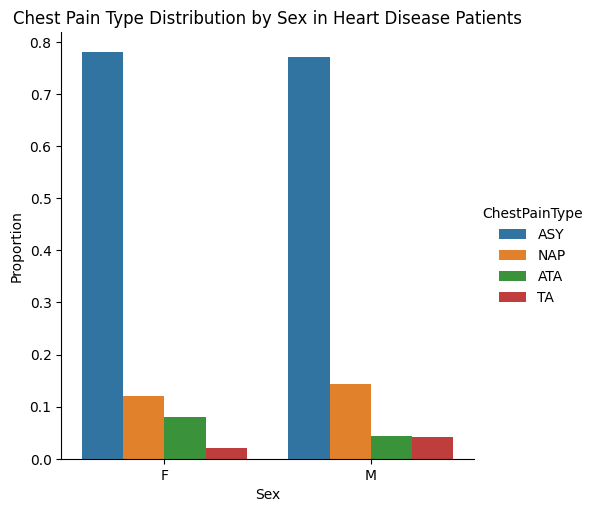

In [17]:
sns.catplot(counts, kind="bar", x="Sex", y="Proportion", hue="ChestPainType")
plt.title("Chest Pain Type Distribution by Sex in Heart Disease Patients")

Observations:
- `ASY` is the most common chest pain type among individuals with heart disease.
- The distributions of `ASY` and `NAP` are relatively similar between males and females.
- Among males, `ATA` and `TA` occur at nearly equal proportions, whereas among females, `ATA` is notably more frequent than `TA`.

While this visual inspection suggests a difference in chest pain distributions between males and females with heart disease, a Chi-squared test of homogeneity can formally assess whether these differences are statistically significant.

In [18]:
contingency = pd.crosstab(df_homogeneity["Sex"], df_homogeneity["ChestPainType"])
contingency

ChestPainType,ASY,ATA,NAP,TA
Sex,,,,
F,39,4,6,1
M,353,20,66,19


In [19]:
chi2_stat, p_chi, df, expected = chi2_contingency(contingency)

print(f"chi2 statistic: {chi2_stat:.4f}")
print(f"p-value: {p_chi:.4f}")

chi2 statistic: 1.9778
p-value: 0.5770


Observations:
- A Chi-squared test statistic of 1.9778 indicates a small difference between the distributions of chest pain types between 
- A p-value of 0.5770 is much larger than our alpha of 0.05

In conclusion, based off of the above results, we fail to reject the null hypothesis as there is insufficient evidence to conclude that chest pain types distributions differ between males and females.

Again, like we have done in other examples, let's plot the $ Chi^2 $ distribution, along with our calculated statistic.

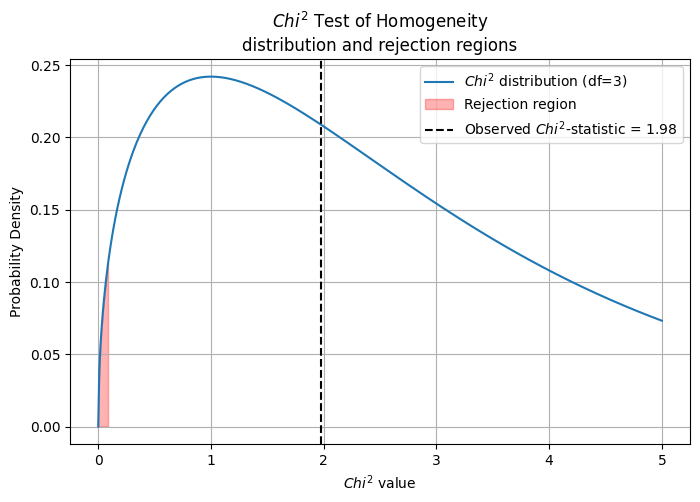

In [20]:
# Parameters
alpha = 0.05

# chi2 distribution is non-negative
x = np.linspace(0, 5, 500)
y = chi2.pdf(x, df)

chi2_crit = chi2.pdf(alpha, df)

plt.figure(figsize=(8, 5))
plt.plot(x, y, label=f'$Chi^2$ distribution (df={df:.0f})')

# shade rejection region
x_fill = np.linspace(0, chi2_crit, 500)
plt.fill_between(x_fill, 0, chi2.pdf(x_fill, df), color='red', alpha=0.3, label='Rejection region')

# mark statistic
plt.axvline(chi2_stat, color='black', linestyle='--', label=f'Observed $Chi^2$-statistic = {chi2_stat:.2f}')

plt.title('$Chi^2$ Test of Homogeneity\ndistribution and rejection regions')
plt.xlabel('$Chi^2$ value')
plt.ylabel('Probability Density')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()